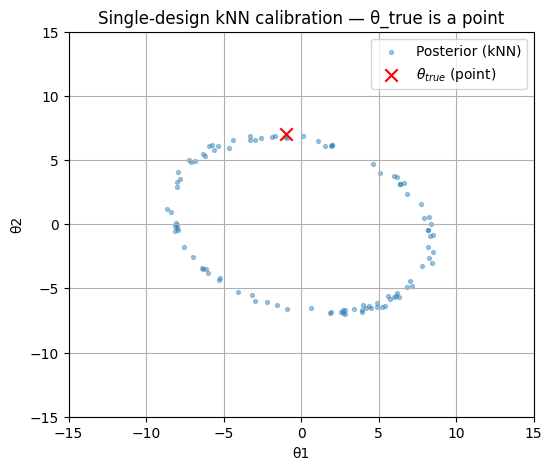

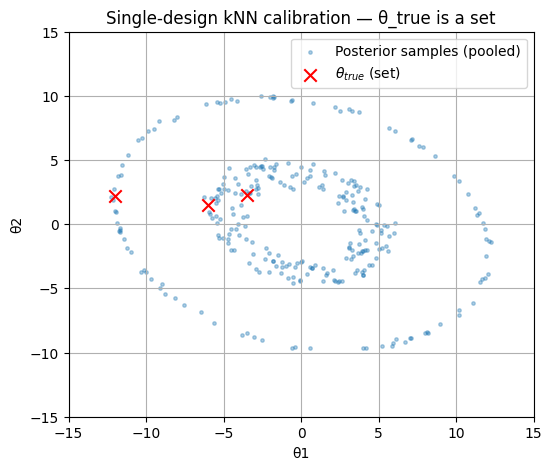

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

from knn import KNNCalibrator  # your revised class

# --- Paraboloid model (vectorized) ---
def paraboloid_model(theta, xi=0.0, A=1.0, B=0.5, C=1.5, noise=True):
    """ Simple quadratic paraboloid with optional Gaussian noise.
    Works for one or many θ samples.
    """
    theta = np.atleast_2d(theta).astype(float)
    x1, x2 = theta[:, 0], theta[:, 1]
    xi = np.asarray(xi, float)
    if xi.ndim == 0:  # scalar
        xi = np.full(theta.shape[0], xi)

    y = A * x1 ** 2 + B * x1 * x2 + C * (x2 + xi) ** 2
    if noise:
        y = y + 3*np.random.randn(theta.shape[0])
    return y.reshape(-1, 1) if theta.shape[0] > 1 else np.array([y.item()])


# --- θ sampler ---
def theta_sampler(n, lb=-15, ub=15):
    return np.random.uniform(lb, ub, size=(n, 2))


# Simulate a dataset (optional, here we show using simulated_data dict)
N_SIM = 25000
xi_baseline = 0.0
theta_sim = theta_sampler(N_SIM)
xi_sim = np.zeros((N_SIM, 1))  # single design
y_sim = np.vstack([paraboloid_model(theta=th, xi=xi_baseline) for th in theta_sim])

simulated_data = {"y": y_sim, "theta": theta_sim, "xi": xi_sim}

# 1) θ_true is a single point
theta_true_point = np.array([np.random.randint(20) - 10, np.random.randint(20) - 10])
y_obs_point = paraboloid_model(theta_true_point).reshape(1, -1)

calib = KNNCalibrator(knn=100)
calib.setup(simulated_data=simulated_data, xi_list=[xi_baseline])  # single-design mode
theta_post_point = calib.calibrate([(y_obs_point, xi_baseline)])

plt.figure(figsize=(6, 5))
plt.scatter(theta_post_point[:, 0], theta_post_point[:, 1],
            s=8, alpha=0.4, label="Posterior (kNN)")
plt.scatter(theta_true_point[0], theta_true_point[1],
            c="r", marker="x", s=80, label=r"$θ_{true}$ (point)")
plt.title("Single-design kNN calibration — θ_true is a point")
plt.xlabel("θ1")
plt.ylabel("θ2")
plt.legend()
plt.grid(True)
plt.xlim([-15, 15])
plt.ylim([-15, 15])
plt.show()

# 2) θ_true are multiple points (repeated experiments with varying θ)
theta_true_set = np.array([    [-6.0, 1.5],
                               [-3.5, 2.3],
                               [-12.0, 2.2],])

y_obs_many = paraboloid_model(theta_true_set)  # 3 rows → 3 observations

theta_post_many = calib.calibrate([(y_obs_many, 0.0)])  # pooled kNN matches

plt.figure(figsize=(6, 5))
plt.scatter(theta_post_many[:, 0], theta_post_many[:, 1],
            s=6, alpha=0.35, label="Posterior samples (pooled)")
plt.scatter(theta_true_set[:, 0], theta_true_set[:, 1],
            c="r", marker="x", s=80, label=r"$θ_{true}$ (set)")
plt.title("Single-design kNN calibration — θ_true is a set")
plt.xlabel("θ1")
plt.ylabel("θ2")
plt.legend()
plt.grid(True)
plt.xlim([-15, 15])
plt.ylim([-15, 15])
plt.show()


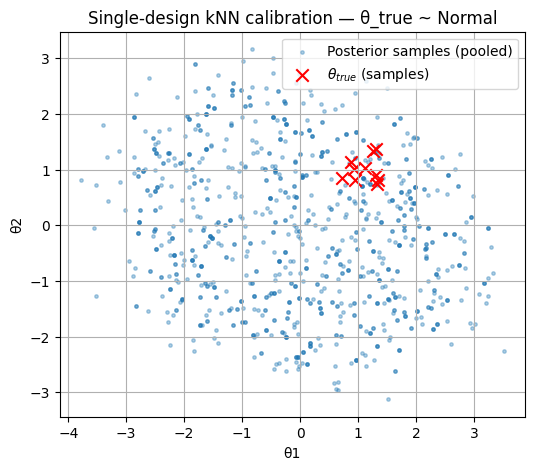

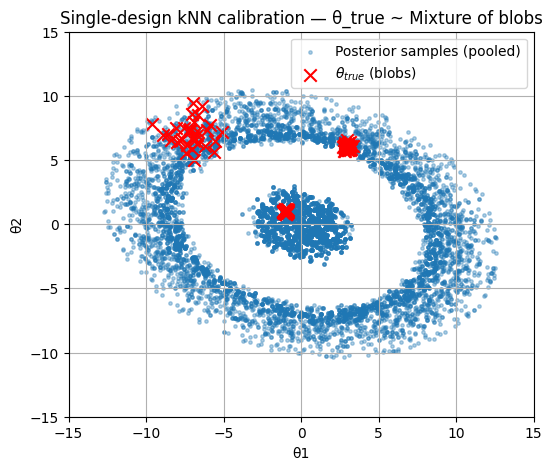

In [6]:
# 3.1) θ_true ~ Normal(1.2, 0.3)
theta_true_sam = np.random.normal(1.2, 0.3, size=(10, 2))
y_obs_many = paraboloid_model(theta_true_sam)

theta_post_many = calib.calibrate([(y_obs_many, 0.0)])  # pooled calibration

plt.figure(figsize=(6, 5))
plt.scatter(theta_post_many[:, 0], theta_post_many[:, 1],
            s=6, alpha=0.35, label="Posterior samples (pooled)")
plt.scatter(theta_true_sam[:, 0], theta_true_sam[:, 1],
            c="r", marker="x", s=80, label=r"$θ_{true}$ (samples)")
plt.title("Single-design kNN calibration — θ_true ~ Normal")
plt.xlabel("θ1"); plt.ylabel("θ2"); plt.legend(); plt.grid(True)
plt.show()


# 3.2) θ_true ~ Mixture of blobs
theta_true_sam, _ = make_blobs(
    n_samples=100,
    centers=[(-1., 1.), (-7., 7.), (3., 6.)],
    cluster_std=(0.1, 1.0, 0.2),
    random_state=42
)
y_obs_many = paraboloid_model(theta_true_sam)

theta_post_many = calib.calibrate([(y_obs_many, 0.0)])  # pooled calibration

plt.figure(figsize=(6, 5))
plt.scatter(theta_post_many[:, 0], theta_post_many[:, 1],
            s=6, alpha=0.35, label="Posterior samples (pooled)")
plt.scatter(theta_true_sam[:, 0], theta_true_sam[:, 1],
            c="r", marker="x", s=80, label=r"$θ_{true}$ (blobs)")
plt.title("Single-design kNN calibration — θ_true ~ Mixture of blobs")
plt.xlabel("θ1"); plt.ylabel("θ2"); plt.legend(); plt.grid(True)
plt.xlim([-15, 15]); plt.ylim([-15, 15]); plt.show()


In [17]:
# True θ (single point)
theta_true = np.array([-4.2, 3.55])

# Three designs
xi1, xi2, xi3 = 0.0, 2.0, -4.0

# Generate observations at each design
rng = np.random.default_rng(42)
y_obs_xi1 = paraboloid_model(theta_true, xi1) + 0.05 * rng.normal(size=1)
y_obs_xi2 = paraboloid_model(theta_true, xi2) + 0.05 * rng.normal(size=1)
y_obs_xi3 = paraboloid_model(theta_true, xi3) + 0.05 * rng.normal(size=1)

# Setup joint calibrator
calib_joint = KNNCalibrator(kernel_bandwidth=None)
calib_joint.setup(model=paraboloid_model,
                  theta_sampler=theta_sampler,
                  xi_list=[xi1, xi2, xi3],
                  n_samples=100000)

# Fuse all datasets (joint posterior)
observations = [(y_obs_xi1, xi1), (y_obs_xi2, xi2), (y_obs_xi3, xi3)]
theta_grid, weights = calib_joint.calibrate(observations, resample_n=None)
theta_post_joint, _ = calib_joint.calibrate(observations, resample_n=3000)



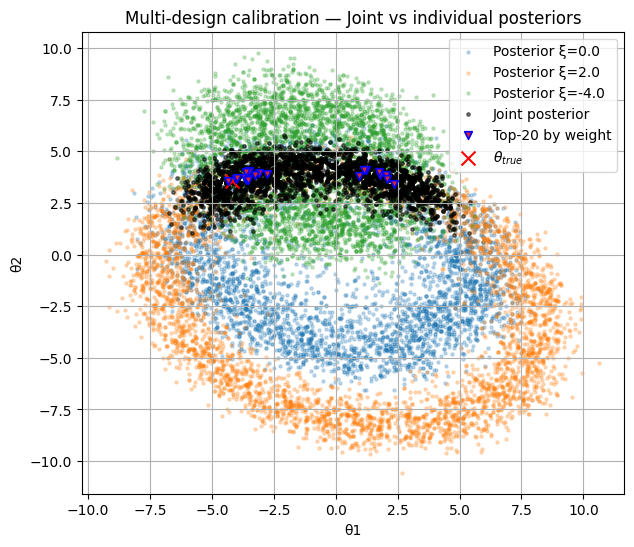

In [18]:
top_k = 20 # Compute top_k before plotting so we can highlight them
idx_top = np.argpartition(weights, -top_k)[-top_k:]
idx_top = idx_top[np.argsort(weights[idx_top])[::-1]]  # descending by weight
# Individual per-design posteriors
posterior_plot_samples = 5000
theta_post_xi1, _ = calib_joint.calibrate([(y_obs_xi1, xi1)], resample_n=posterior_plot_samples)
theta_post_xi2, _ = calib_joint.calibrate([(y_obs_xi2, xi2)], resample_n=posterior_plot_samples)
theta_post_xi3, _ = calib_joint.calibrate([(y_obs_xi3, xi3)], resample_n=posterior_plot_samples)

# Plot: joint vs individual
plt.figure(figsize=(7, 6))
plt.scatter(theta_post_xi1[:, 0], theta_post_xi1[:, 1], s=5, alpha=0.25, label=f"Posterior ξ={xi1}")
plt.scatter(theta_post_xi2[:, 0], theta_post_xi2[:, 1], s=5, alpha=0.25, label=f"Posterior ξ={xi2}")
plt.scatter(theta_post_xi3[:, 0], theta_post_xi3[:, 1], s=5, alpha=0.25, label=f"Posterior ξ={xi3}")
plt.scatter(theta_post_joint[:, 0], theta_post_joint[:, 1], s=6, alpha=0.5, c="k", label="Joint posterior")

plt.scatter(theta_grid[idx_top, 0], theta_grid[idx_top, 1], s=30, marker='v', edgecolors='b',
           linewidths=1.2, zorder=6, label=f"Top-{top_k} by weight")


plt.scatter(theta_true[0], theta_true[1], c="r", marker="x", s=100, label=r"$θ_{true}$")
plt.title("Multi-design calibration — Joint vs individual posteriors")
plt.xlabel("θ1"); plt.ylabel("θ2"); plt.legend(); plt.grid(True)
plt.show()


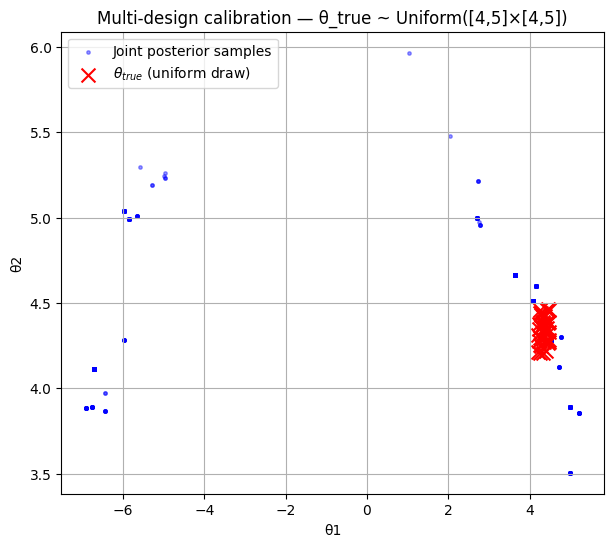

In [30]:
# --- True θ sampled from Uniform([4,5] × [4,5]) ---
rng = np.random.default_rng(123)
theta_true = rng.uniform(4.2, 4.5, size=(40, 2))  # shape (1,2)

# Three designs
xi_list = [0.0, 2.0, -3]

# Generate observations at each design
observations = []

for xi in xi_list:
    y_obs_ith = paraboloid_model(theta_true, xi)
    observations.append((y_obs_ith,xi))


# Setup joint calibrator
calib_joint = KNNCalibrator(knn=200, kernel_bandwidth=None)
calib_joint.setup(model=paraboloid_model,
                  theta_sampler=theta_sampler,
                  xi_list=xi_list,
                  n_samples=10000)

# Fuse all datasets (joint posterior)
theta_grid, weights = calib_joint.calibrate(observations, resample_n=None)
theta_post_joint, _ = calib_joint.calibrate(observations, resample_n=1000)

# --- Plot joint posterior ---
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
plt.scatter(theta_post_joint[:, 0], theta_post_joint[:, 1],
            s=6, alpha=0.4, c="b", label="Joint posterior samples")
plt.scatter(theta_true[:, 0], theta_true[:, 1],
            c="r", marker="x", s=100, label=r"$θ_{true}$ (uniform draw)")
plt.title("Multi-design calibration — θ_true ~ Uniform([4,5]×[4,5])")
plt.xlabel("θ1"); plt.ylabel("θ2"); plt.grid(True); plt.legend()
plt.show()


In [31]:
# Already simulated data
theta_sim = np.random.uniform(-10, 10, size=(50000, 2))      # (N, d_theta)
xi_sim = np.zeros((50000, 1))                                # (N, d_xi)
y_sim = np.vstack([paraboloid_model(th, xi=0.0) for th in theta_sim])  # (N, d_y)

# Wrap into dict
simulated_data = {"y": y_sim, "theta": theta_sim, "xi": xi_sim}

# Setup calibrator with precomputed dataset
calib = KNNCalibrator(knn=50)
calib.setup(simulated_data=simulated_data, xi_list=[0.0])  # single-design mode

# Use with new observation
theta_true = np.array([4.2, 3.7])
y_obs = paraboloid_model(theta_true, xi=0.0).reshape(1, -1)
theta_post = calib.calibrate([(y_obs, 0.0)])


In [34]:
def paraboloid_model(theta, xi=0):
  x1, x2 = theta
  return np.array([x1**2 + 0.5*x1*x2 + (x2+xi)**2])
def theta_sampler(n): return np.random.uniform(-5, 5, size=(n, 2))

calib = KNNCalibrator(knn=50)
calib.setup(model=paraboloid_model, theta_sampler=theta_sampler, xi_list=[0.0], n_samples=5000)
xi_base= 2.2
y_obs = paraboloid_model([-4, 2.5], xi=xi_base).reshape(1, -1)
theta_post = calib.calibrate([(y_obs, xi_base)])

theta_post

array([[-4.54938277, -2.56299474],
       [-4.42241635, -2.73822542],
       [ 4.26379995,  2.94378841],
       [ 4.07158556,  3.17587638],
       [-4.68447175, -2.36122472],
       [-2.3001689 , -4.73274019],
       [-4.47760256, -2.66806057],
       [ 3.67079098,  3.6113792 ],
       [ 4.01718674,  3.22625559],
       [ 4.71899549, -4.68371944],
       [-4.47858619, -2.67168424],
       [-4.17102672, -3.04263327],
       [ 2.23892483,  4.77742496],
       [-4.72870765,  4.67967469],
       [ 3.72986722,  3.5569326 ],
       [ 4.61727462, -4.78988649],
       [ 4.74184345, -4.63250218],
       [-2.05732276, -4.89404172],
       [-3.43944967, -3.81627662],
       [ 1.89810768,  4.9886655 ],
       [-3.2205338 , -4.01312356],
       [-3.78106638, -3.47153553],
       [-2.68406124, -4.47849491],
       [ 4.49847307,  2.65841892],
       [ 3.21100405,  4.05707488],
       [-3.03916429, -4.20347725],
       [-4.76746535,  4.6551012 ],
       [ 4.02428056,  3.19833229],
       [ 3.27998751,